In [1]:
import os
import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import Tracking_Fatigue as fatigue
import helpers
import importlib
# importlib.reload(tracab)
# importlib.reload(helpers)
# importlib.reload(vis)

# Model 2

# Read player and energy expenditure data

In [2]:
# EX data
with open(os.path.join('./saved/all_time_series.pkl'), 'rb') as infile:
    data_dict = pickle.load(infile)

FileNotFoundError: [Errno 2] No such file or directory: './saved/all_time_series.pkl'

In [275]:
# players data
players_df = pd.read_csv('../playerid_jerseynum_map.csv')

In [276]:
players_df.head()

,Match ID,Team,Playerid,Player name,Jersey Num,Starting Position,Starts Match,start_pos_super,first_name,last_name
0,984455,Home,50310,Sebastian Mielitz,28,GK,Start,GK,Sebastian,Mielitz
1,984455,Home,247047,Nicholas Marfelt,18,LFB,Start,FB,Nicholas,Marfelt
2,984455,Home,207273,Stefan Gartenmann,2,RFB,Start,FB,Stefan,Gartenmann
3,984455,Home,56317,Kees Luijckx,5,CD,Start,CB,Kees,Luijckx
4,984455,Home,52560,Marc Pedersen,3,CD,Start,CB,Marc,Pedersen


In [277]:
# for player, positions in players_df[['Playerid', 'start_pos_super']]\
#         .groupby('Playerid')['start_pos_super'].apply(list).iteritems():
#     print(player, np.unique(positions))

In [278]:
# players_df[players_df['Playerid']==45097]

In [279]:
# players_df[['Match ID', 'Playerid', 'start_pos_super']]

# Fatigue Model

## Fit 2nd degree polynomial on energy expenditure

In [280]:
from scipy.optimize import curve_fit
from collections import defaultdict

In [281]:
def poly_2nd(x, b, c):
    return 0 + (b * x) + (c * x ** 2)

def plays_full_game(EX_series, thresh=0.95):
    is_full = np.count_nonzero(EX_series)/len(EX_series) > thresh 
    return is_full

In [282]:
coefs = []

# for each game
for match_id, data in data_dict.items():    
    for _, player_id, series in data['energy_x']:
        EX_cumul = np.cumsum(series)
        frame_lst = np.array(range(len(EX_cumul)))
        
        # check if is subbed out
        if not plays_full_game(series):
            continue
        
        # fit second degree polynomial that passes through origin
        popt, pcov = curve_fit(poly_2nd, frame_lst, EX_cumul)
        
        
        # store info
        coefs.append([match_id, player_id, *popt, *np.sqrt(np.diag(pcov))])
        
    print('Done with match {}'.format(match_id))

Done with match 984554
Done with match 984509
Done with match 984590
Done with match 984539
Done with match 984530
Done with match 984481
Done with match 984495
Done with match 984468
Done with match 984460
Done with match 984523
Done with match 984570
Done with match 984579
Done with match 984505
Done with match 984558
Done with match 984476
Done with match 984491
Done with match 984455
Done with match 984518
Done with match 984544
Done with match 984575


In [283]:
# dataframe of coefficients
df_coefs = pd.DataFrame(coefs, 
                        columns=['match_id', 'player_id', 'b1', 'b2', 'sigma_b1', 'sigma_b2'])

In [284]:
df_coefs.sample(5)

,match_id,player_id,b1,b2,sigma_b1,sigma_b2
312,984575,144045,3.723661,-0.000005,0.000583,5.278366e-09
184,984579,210956,9.007833,-0.000011,0.001224,1.094715e-08
42,984590,182413,3.285198,0.000001,0.000783,6.905114e-09
26,984509,209721,11.396292,-0.000015,0.001058,9.417746e-09
305,984544,102005,8.688160,0.000009,0.002157,1.916223e-08


## Merge player data

In [285]:
# add in info 
df_coefs_w_info = pd.merge(df_coefs.astype({'match_id':int}),
                            players_df[['Match ID', 'Playerid', 'start_pos_super', 'Team']],
                            left_on=['match_id', 'player_id'],
                            right_on=['Match ID', 'Playerid'],
                            how='left').drop(['Match ID', 'Playerid'], axis=1)

# Distribution of coefficients

In [286]:
# get players who play the most, filter out player with few games
n_games = df_coefs['player_id'].value_counts()
most_play_players = n_games[n_games > 5]

In [287]:
# distribution per player
coefs_per_player = df_coefs_w_info.set_index('player_id')\
                                  .loc[most_play_players.index]\
                                  .reset_index()

In [288]:
coefs_per_player.head()

,player_id,match_id,b1,b2,sigma_b1,sigma_b2,start_pos_super,Team
0,182413,984554,3.335275,2.965753e-06,0.000890,7.704964e-09,GK,Away
1,182413,984509,3.385095,-2.696467e-06,0.000519,4.615550e-09,GK,Home
2,182413,984590,3.285198,1.225754e-06,0.000783,6.905114e-09,GK,Away
3,182413,984539,3.463827,-9.692025e-07,0.001054,9.182158e-09,GK,Away
4,182413,984530,4.153215,-4.116080e-06,0.000800,7.014023e-09,GK,Home


### B1

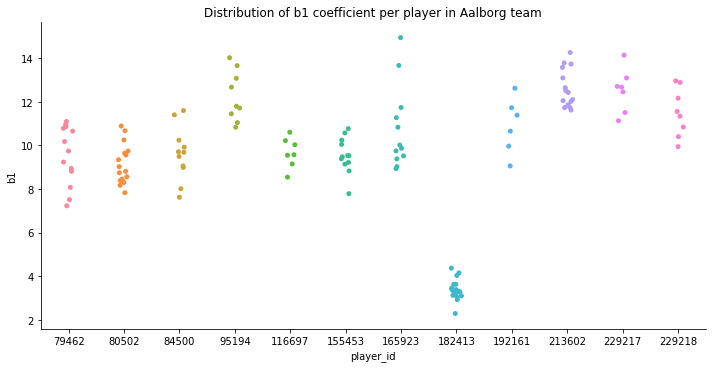

In [289]:
# plot b1
sns.catplot(data=coefs_per_player, x='player_id', y='b1', height=5, aspect=2)
plt.title('Distribution of b1 coefficient per player in Aalborg team')
plt.show()

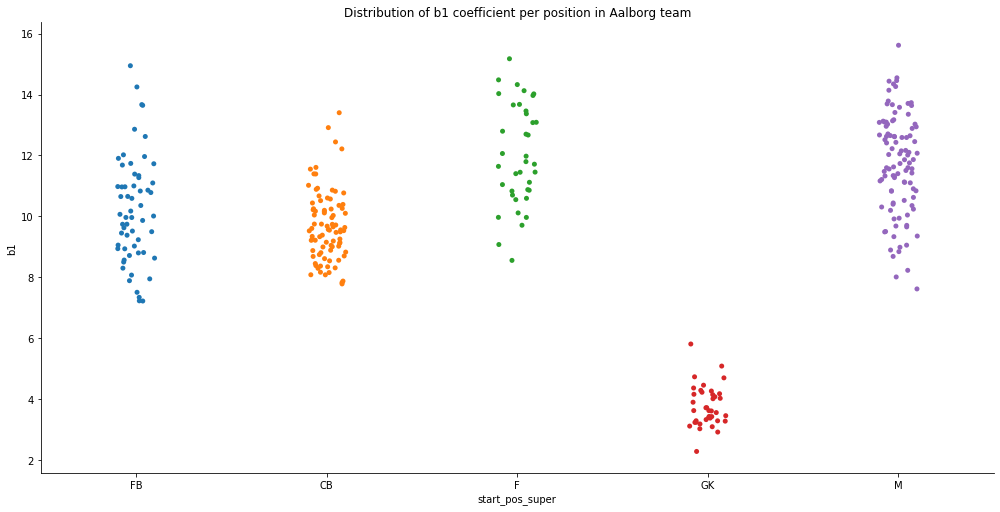

In [291]:
# per position
g = sns.catplot(data=df_coefs_w_info, 
            x='start_pos_super', y='b1',
              
            height=7, aspect=2)
plt.title('Distribution of b1 coefficient per position in Aalborg team')
# g._legend.remove()

# g.map(plt.errorbar, "start_pos_super", "b1", "sigma_b1", marker=".")

plt.show()

### B2

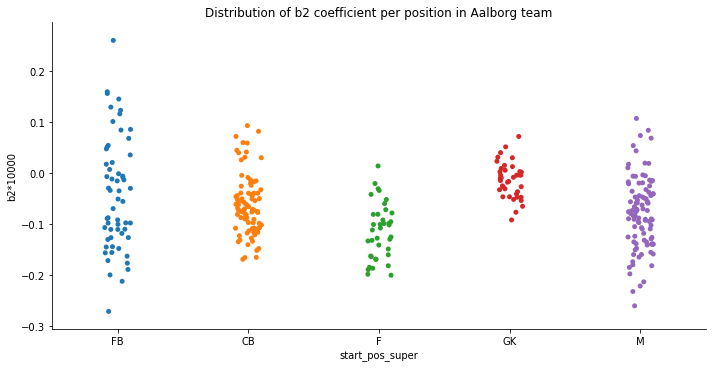

In [292]:
# coef b2

# needed because of seaborn problem
df_coefs_w_info['b2*10000'] =  df_coefs_w_info['b2'] * 10000

# plot
sns.catplot(data=df_coefs_w_info, x='start_pos_super', y='b2*10000', height=5, aspect=2)
plt.title('Distribution of b2 coefficient per position in Aalborg team')
plt.show()

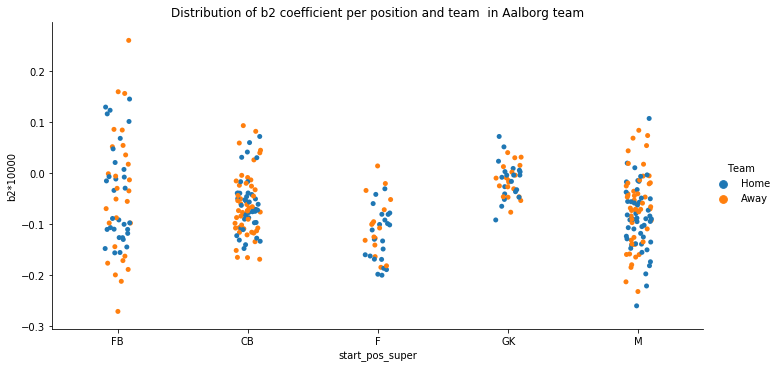

In [302]:
# plot
g = sns.catplot(data=df_coefs_w_info, 
            x='start_pos_super', y='b2*10000', hue='Team',
            height=5, aspect=2)
plt.title('Distribution of b2 coefficient per position and team  in Aalborg team')
g._legend = None
plt.show()

# Anomalies

### B2 coefficient positive

In [309]:
coefs_per_player['b2']

71     0.000026
60     0.000016
55     0.000016
130    0.000012
61     0.000010
         ...   
132   -0.000018
103   -0.000018
101   -0.000019
68    -0.000021
73    -0.000027
Name: b2, Length: 135, dtype: float64

In [316]:
def plot_anomaly():
    # find anomaly
    b2_anomalies = coefs_per_player[coefs_per_player['b2']>0].sort_values('b2', ascending=False)
    b2_abomaly_toplot = b2_anomalies[:5].sample()
    print(b2_abomaly_toplot)

    # get EX series
    b2_anomaly_EX_series = np.cumsum([y for (_, x, y) in data_dict[str(b2_abomaly_toplot['match_id'].values[0])]['energy_x'] 
                                         if x == b2_abomaly_toplot['player_id'].values[0]][0])

    # fit poly
    xs = np.array(range(len(b2_anomaly_EX_series)))
    poly_fit = (b2_abomaly_toplot['b1'].values[0] * xs) + (b2_abomaly_toplot['b2'].values[0] * xs ** 2)

    # plot 
    f, ax = plt.subplots(figsize=(9, 6))
    ax.plot(b2_anomaly_EX_series)
    ax.plot(poly_fit, 'r')
    plt.title('Cumulative energy expanded for player {} in game {} in position {} with its polynomial fit'.format(
                     *[b2_abomaly_toplot[x].values[0] for x in ['player_id', 'match_id', 'start_pos_super']]))
    plt.show()

    player_id  match_id        b1        b2  sigma_b1      sigma_b2  \
71     165923    984476  9.027984  0.000026  0.002815  2.546584e-08   

   start_pos_super  Team  
71              FB  Away  


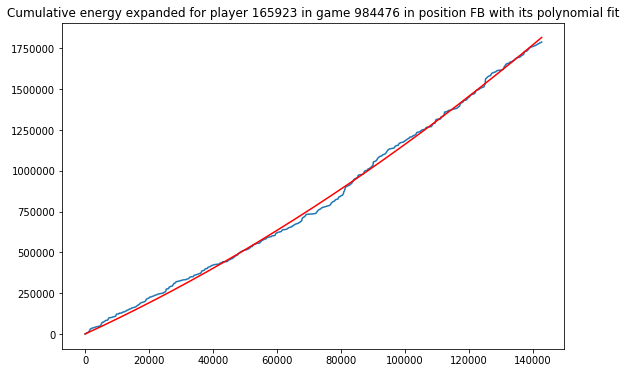

In [317]:
plot_anomaly()

In [318]:
b2_abomaly_toplot

,player_id,match_id,b1,b2,sigma_b1,sigma_b2,start_pos_super,Team
93,84500,984558,7.622336,0.000002,0.001032,8.962667e-09,M,Home


# Bad fits

## B1

In [320]:
top5_bad_b1_fit = coefs_per_player.sort_values('sigma_b1', ascending=False).head()

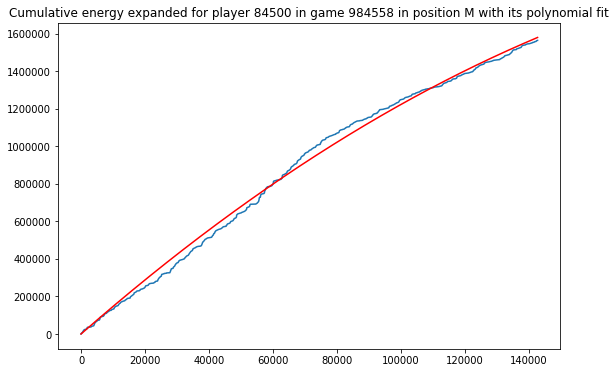

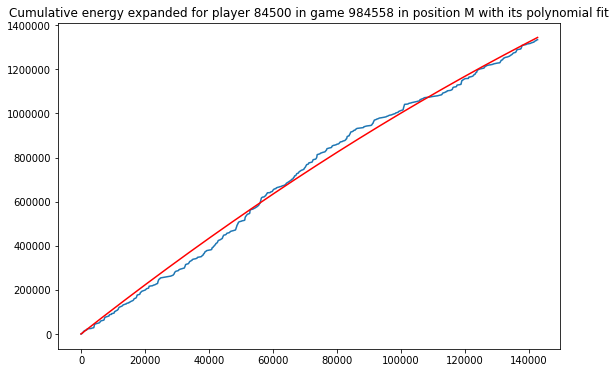

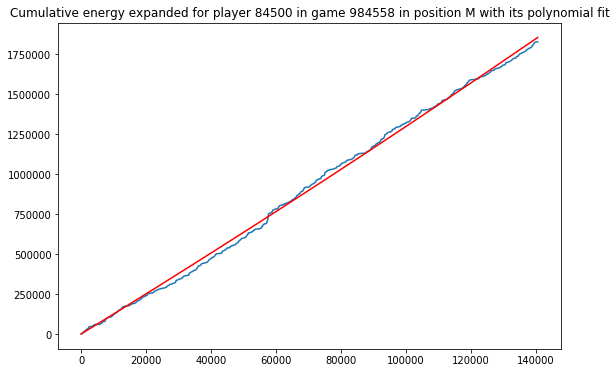

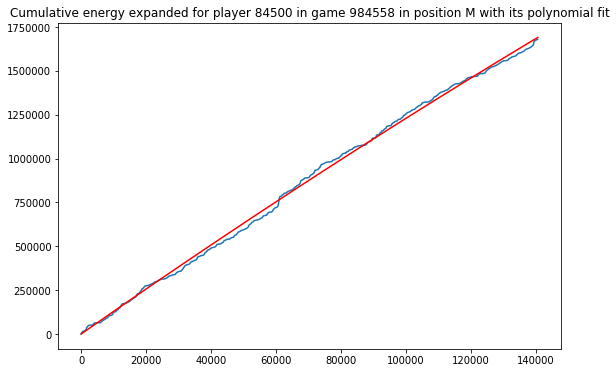

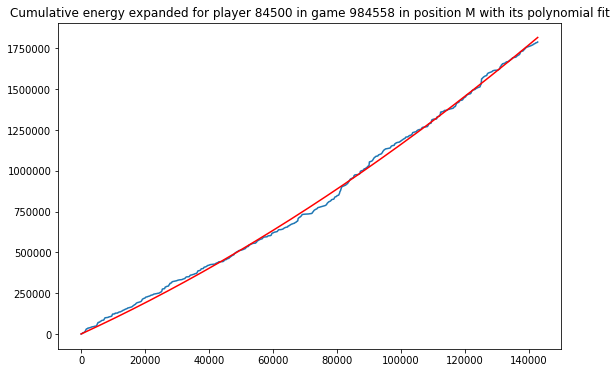

In [321]:
for (player_id, match_id, b1, b2, sigma_b1, sigma_b2, pos, Team) in top5_bad_b1_fit.values:
    EX_series = np.cumsum([y for (_, x, y) in data_dict[str(match_id)]['energy_x'] 
                            if x == player_id][0])
    # fit poly
    xs = np.array(range(len(EX_series)))
    poly_fit = (b1* xs) + (b2 * xs ** 2)

    # plot 
    f, ax = plt.subplots(figsize=(9, 6))
    ax.plot(EX_series)
    ax.plot(poly_fit, 'r')
    plt.title('Cumulative energy expanded for player {} in game {} in position {} with its polynomial fit'.format(
                     *[b2_abomaly_toplot[x].values[0] for x in ['player_id', 'match_id', 'start_pos_super']]))
    plt.show()
    

## B2

In [322]:
top5_bad_b2_fit = coefs_per_player.sort_values('sigma_b2', ascending=False).head()

[array([0.11, 0.08, 0.07, ..., 1.1 , 1.12, 1.15])]


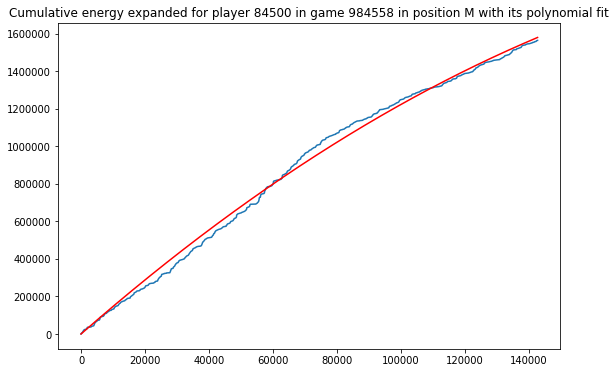

In [323]:
for (player_id, match_id, b1, b2, sigma_b1, sigma_b2, pos, Team) in top5_bad_b2_fit.values:
    print([y for (_, x, y) in data_dict[str(match_id)]['energy_x'] 
                            if x == player_id])
    EX_series = np.cumsum([y for (_, x, y) in data_dict[str(match_id)]['energy_x'] 
                            if x == player_id][0])
    # fit poly
    xs = np.array(range(len(EX_series)))
    poly_fit = (b1* xs) + (b2 * xs ** 2)

    # plot 
    f, ax = plt.subplots(figsize=(9, 6))
    ax.plot(EX_series)
    ax.plot(poly_fit, 'r')
    plt.title('Cumulative energy expanded for player {} in game {} in position {} with its polynomial fit'.format(
                     *[b2_abomaly_toplot[x].values[0] for x in ['player_id', 'match_id', 'start_pos_super']]))
    plt.show()
    
    
    break
    

# b1 vs b2

In [346]:
data_b2_adapted = coefs_per_player
data_b2_adapted['b2'] = data_b2_adapted['b2'] * 1000

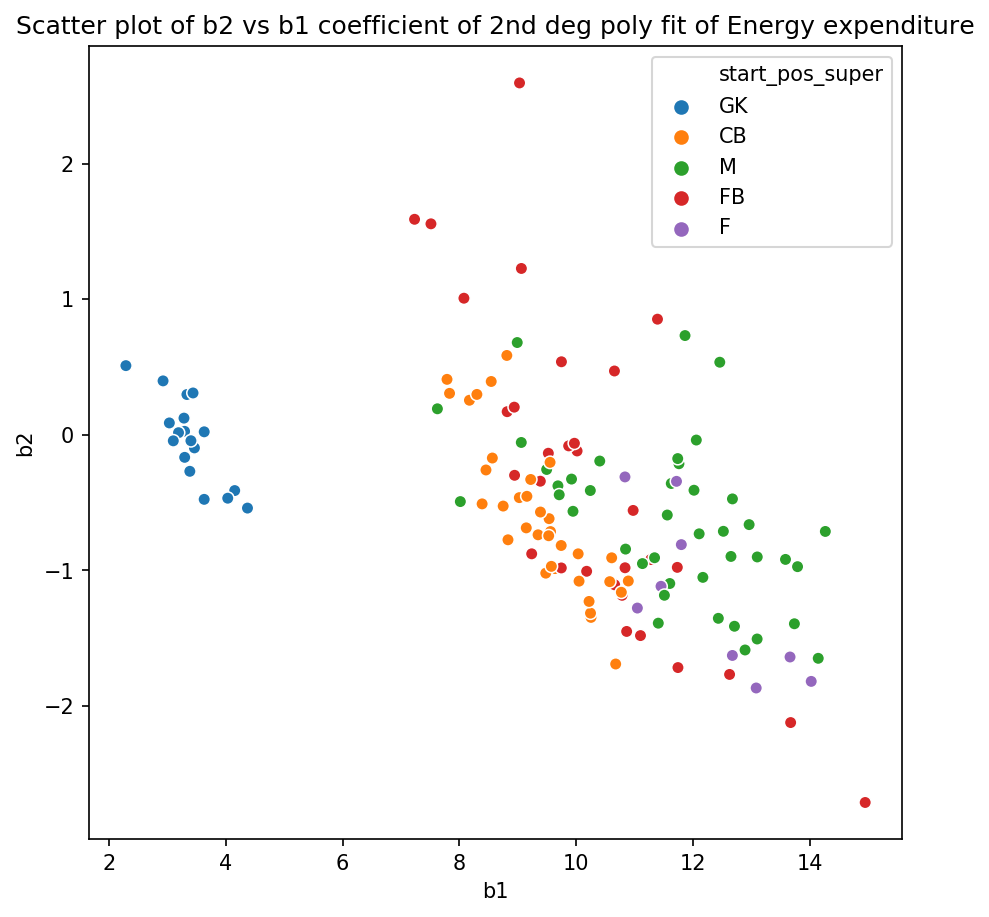

In [351]:
# plot b1 vs b2 
f, ax = plt.subplots(figsize=(7, 7), dpi=150)
sns.scatterplot(data=coefs_per_player,
            x='b1', y='b2', hue='start_pos_super', ax=ax)
plt.title('Scatter plot of b2 vs b1 coefficient of 2nd deg poly fit of Energy expenditure')
plt.show()

In [330]:
df_coefs_w_info['b1'].describe()

count    322.000000
mean       9.970039
std        2.870798
min        2.290904
25%        8.882741
50%       10.257463
75%       11.844552
max       15.615417
Name: b1, dtype: float64

In [331]:
df_coefs_w_info['b2'].describe()

count    322.000000
mean      -0.000006
std        0.000008
min       -0.000027
25%       -0.000011
50%       -0.000007
75%       -0.000002
max        0.000026
Name: b2, dtype: float64

# Integrate player features to model
### Get player features

In [579]:
# read  player data
danish_player_data = pd.read_csv('../DanishSuperLiga_1819_PlayerData.csv')

# get player id to name mapping
name_and_id = players_df[['Playerid', 'Player name', 'first_name', 'last_name']].drop_duplicates()

# split first and last name
first_last = danish_player_data['Player'].str.split(expand=True, n=1)
first_last.columns = ['first_name', 'last_name']
danish_player_data[['first_name', 'last_name']] = first_last

In [575]:
# get player id in the player data
for i, first, last, name in danish_player_data[['first_name', 'last_name', 'Player']].reset_index().values:
    # last name
    last_matches = name_and_id['Player name'].str.contains(last)
    
    # first name
    if last_matches.any():
        first_matches = name_and_id[last_matches]['first_name'].str.slice(stop=1).str.contains(first[0])
        if len(first_matches[first_matches].index) == 1:
            p_id = name_and_id.loc[first_matches[first_matches].index]['Playerid']
            
            # set
            danish_player_data.loc[i, 'player_id'] = p_id.values[0]
        else:
            print(len(first_matches[first_matches].index))


R. Skov
482092

A. Skov Olsen
None

V. Fischer
None

P. Onuachu
0

D. Vavro
None

M. Duelund
None

B. Sanneh
None

Evander Evander
None

H. Mukhtar
None

P. Ankersen
None

R. Falk
None

V. Nelsson
None

M. Jensen
3

J. Andersson
None

S. Tibbling
None

J. Joronen
None

A. Bjelland
None

Zeca Zeca

K. Bartolec
None

E. Sviatchenko
None

A. Scholz
None

A. Mabil
None

C. Nørgaard

M. Damsgaard
None

M. Kofod Andersen

J. Wind
None

J. Greguš

S. Hedlund
None

G. Donyoh
None

A. Petre
None

J. Lungi Sørensen

N. Boilesen
None

G. Varela
None

N. Thomsen
None

L. Andersen
None

K. Hansen
2

M. Dal Hende
None

G. Wikheim
None

F. Onyeka
None

L. Vigen Christensen
None

J. Larsson
None

R. Kurzawa
None

K. Wilczek
None

J. Radošević

P. Sotiriou
None

R. Mudražija

L. Parunashvili
None

M. Kristensen
2

T. van Weert
None

K. Kusk
None

J. Okore
None

M. Bundu
None

S. Grytebust
None

S. Papagiannopoulos
None

J. Stage
None

A. Jovanović

M. Schwäbe

M. Jørgensen

M. Daramy
None

U. Yttergår

## Build dataset with player info and EX

In [603]:
# mean EX per player
EX_mean_and_info = pd.merge(
    df_coefs_w_info.groupby('player_id')[['b1', 'b2']].mean().reset_index(),
    danish_player_data,
    on='player_id'
)

In [623]:
# add in multiple of b2 for visualization perposes
EX_mean_and_info['b2*10000'] = EX_mean_and_info['b2'] * 10000

In [704]:
EX_mean_and_info.T

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
player_id,13994,18150,39737,48337,48469,48601,48733,49829,50310,51585,...,423807,424528,429773,430368,435556,440089,445731,449897,451410,451411
b1,10.1994,13.1257,9.62725,8.55815,7.95185,10.9679,9.74907,11.2069,4.23239,8.50272,...,10.4421,8.34932,12.4114,14.4242,9.07847,14.4377,13.639,11.2739,9.64363,13.0248
b2,-1.31707e-05,-1.79855e-05,-1.2663e-05,-2.08184e-06,8.38997e-06,-6.99668e-06,-8.45174e-06,-1.20513e-05,-4.26639e-07,6.76091e-06,...,-8.23558e-06,7.13021e-06,-1.07182e-05,-1.3508e-05,-7.20714e-06,-1.47713e-05,-1.26288e-05,-1.59922e-05,-4.68275e-06,-1.55559e-05
Player,J. Poulsen,T. Sparv,P. Nymann,D. N'Doye,P. Bengtsson,P. Kristensen,R. Leeuwin,M. Halsti,S. Mielitz,D. Christensen,...,B. Jacobsen,R. Minor Petersen,M. Haarup,A. Skov Olsen,O. Drost,M. Damsgaard,N. Strunck Jakobsen,J. Christensen,A. Kaltoft,M. Frankoch
Team,Midtjylland,Midtjylland,Horsens,København,København,AaB,OB,Esbjerg,SønderjyskE,Vendsyssel,...,Horsens,Hobro,Hobro,Nordsjælland,NaN,Nordsjælland,Nordsjælland,Nordsjælland,Vendsyssel,Vendsyssel
Position,"RCMF, LCMF","RCMF, LCMF","RB, RW",CF,"LB, LWB",RB,RCB3,"LCB, RCB",GK,"LB, LWB, LB5",...,"LCMF, RCMF",LCB,"LB, RB","CF, RWF",CF,"LCMF3, AMF, CF","RCMF, RCMF3, LCMF","DMF, RCMF, LCMF","LCB, LCB3","DMF, RCMF, LCMF"
Age,36,32,36,34,31,32,31,35,30,30,...,25,30,23,19,23,19,19,18,21,23
Market value,400000,400000,150000,900000,600000,200000,700000,200000,400000,350000,...,600000,350000,350000,8000000,300000,1750000,600000,800000,350000,300000
Contract expires,2020-06-30,2020-06-30,2020-06-30,2020-06-30,2022-06-30,NaN,2020-06-30,2020-06-30,2020-06-30,2020-06-30,...,2021-06-30,2020-06-30,NaN,2020-06-30,NaN,2022-06-30,2021-06-30,NaN,2020-06-30,2020-06-30
Matches played,34,21,33,33,15,14,23,33,34,14,...,31,33,31,36,21,31,20,22,31,13


In [678]:
EX_mean_and_info.head()

,player_id,b1,b2,Player,Team,Position,Age,Market value,Contract expires,Matches played,...,xA,Birth country,Passport country,Foot,Height,Weight,On loan,first_name,last_name,b2*10000
0,13994,10.199429,-0.000013,J. Poulsen,Midtjylland,"RCMF, LCMF",36,400000,2020-06-30,34,...,7.08,Denmark,Denmark,right,181,74,no,J.,Poulsen,-0.131707
1,18150,13.125744,-0.000018,T. Sparv,Midtjylland,"RCMF, LCMF",32,400000,2020-06-30,21,...,0.21,Finland,Finland,left,194,78,no,T.,Sparv,-0.179855
2,39737,9.627246,-0.000013,P. Nymann,Horsens,"RB, RW",36,150000,2020-06-30,33,...,1.33,Denmark,Denmark,right,179,75,no,P.,Nymann,-0.126630
3,48337,8.558148,-0.000002,D. N'Doye,København,CF,34,900000,2020-06-30,33,...,2.44,Senegal,Senegal,right,186,81,no,D.,N'Doye,-0.020818
4,48469,7.951846,0.000008,P. Bengtsson,København,"LB, LWB",31,600000,2022-06-30,15,...,2.38,Sweden,Sweden,left,175,72,no,P.,Bengtsson,0.083900


## Age

In [ ]:
# b1
sns.catplot(x='Age', y='b1*10000',
            data=pd.merge(df_coefs_w_info[['player_id', 'start_pos_super']],
         EX_mean_and_info,
         how='left',
         left_on='player_id', right_on='player_id'
        ), hue='start_pos_super',
           aspect=2, height=7)

plt.title('Scatter plot of mean player b1 coefficient (of EX fit) by Age')
plt.show()

In [687]:
a = pd.merge(df_coefs_w_info[['player_id', 'start_pos_super']],
         EX_mean_and_info,
         how='left',
         left_on='player_id', right_on='player_id'
        )


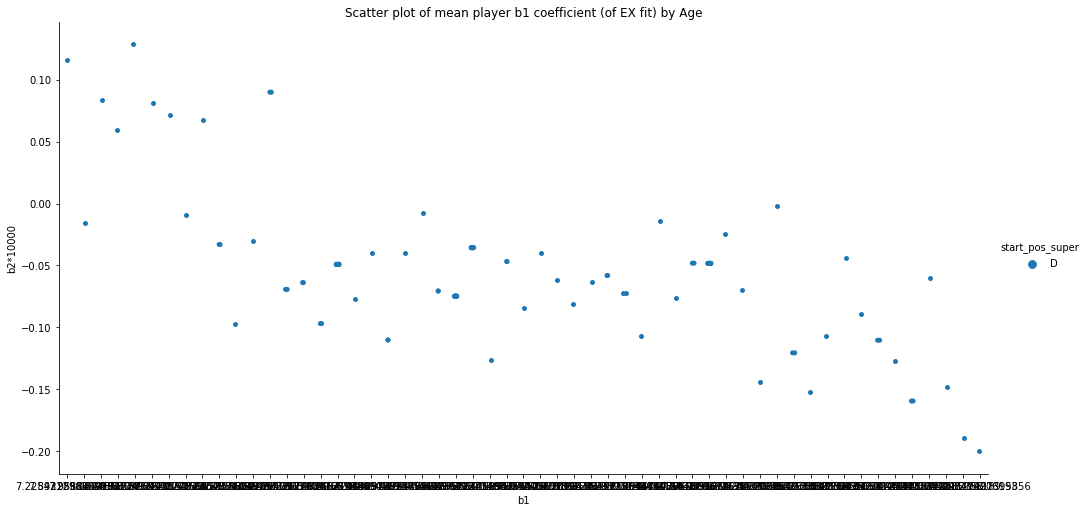

In [695]:
# b1
sns.catplot(x='b1', y='b2*10000',
            data=a[a['start_pos_super'] == 'D'], hue='start_pos_super',
           aspect=2, height=7)

plt.title('Scatter plot of mean player b1 coefficient (of EX fit) by Age')
plt.show()

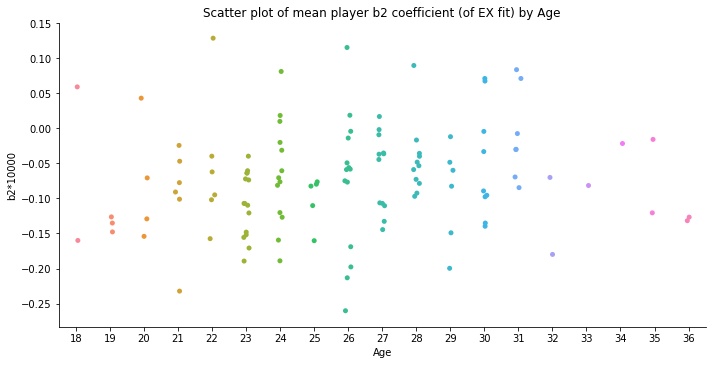

In [672]:
# b2
sns.catplot(x='Age', y='b2*10000',
            data=EX_mean_and_info,
           aspect=2, height=5)

plt.title('Scatter plot of mean player b2 coefficient (of EX fit) by Age')
plt.show()

# Weight

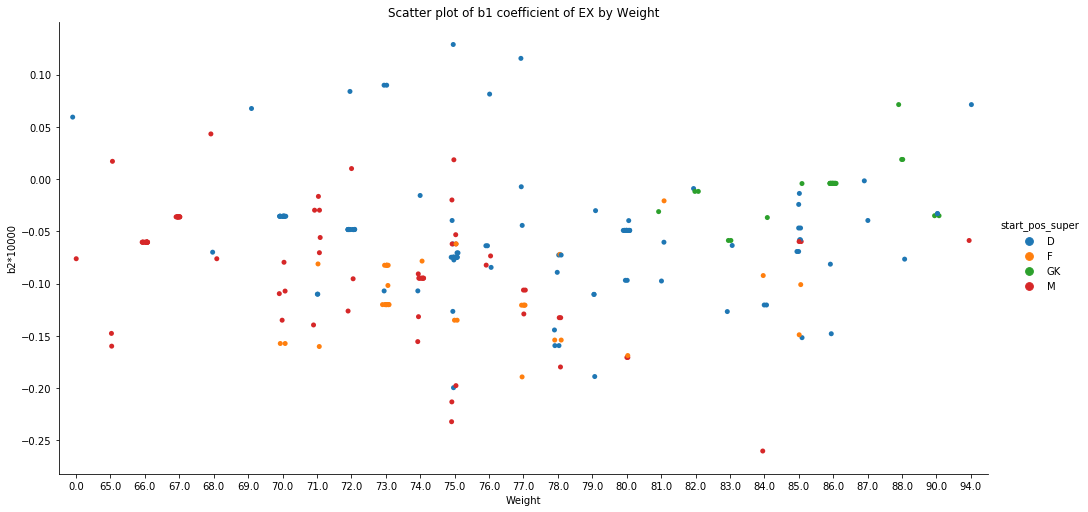

In [703]:
data = pd.merge(df_coefs_w_info[['player_id', 'start_pos_super']],
         EX_mean_and_info,
         how='left',
         left_on='player_id', right_on='player_id'
        )

sns.catplot(x='Weight', y='b2*10000', 
            data=data, hue='start_pos_super',
           aspect=2, height=7)

plt.title('Scatter plot of b1 coefficient of EX by Weight')
plt.show()

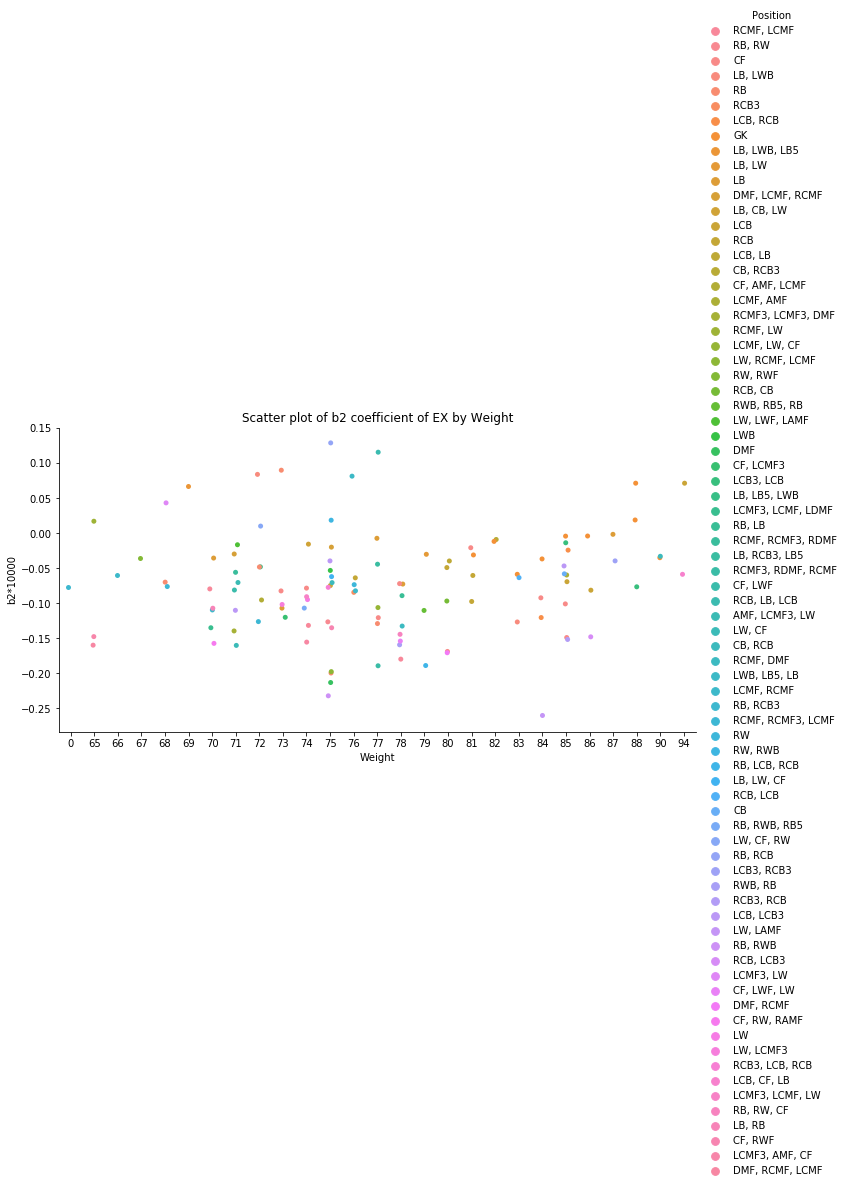

In [696]:
sns.catplot(x='Weight', y='b2*10000', hue='Position',
            data=EX_mean_and_info,
           aspect=2, height=5)

plt.title('Scatter plot of b2 coefficient of EX by Weight')
plt.show()

# Other

In [634]:
EX_mean_and_info.keys()

Index(['player_id', 'b1', 'b2', 'Player', 'Team', 'Position', 'Age',
       'Market value', 'Contract expires', 'Matches played', 'Minutes played',
       'Goals', 'xG', 'Assists', 'xA', 'Birth country', 'Passport country',
       'Foot', 'Height', 'Weight', 'On loan', 'first_name', 'last_name',
       'b2*10000'],
      dtype='object')

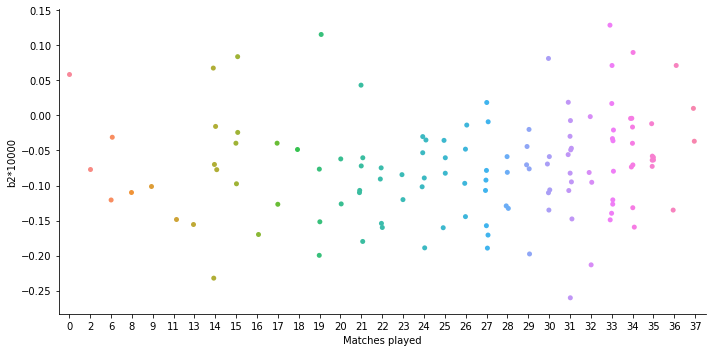

In [662]:
sns.catplot(x='Matches played', y='b2*10000', 
            data=EX_mean_and_info,
           aspect=2, height=5)

plt.title('')
plt.show()

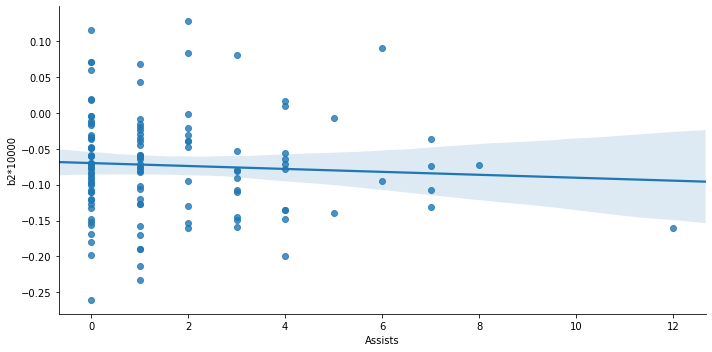

In [659]:
sns.lmplot(x='Assists', y='b2*10000', 
            data=EX_mean_and_info,
           aspect=2, height=5)

plt.title('')
plt.show()